### Triple Barrier Methods

여기서는 학계 논문에서 보지 못한 대체 labeling 기법을 소개한다. 독자들이 투자 전문가라면 이 방법이 더 합리적이라는 것에 공감하리라 생각한다. 저자 Lopez de Prado는 이를 Triple Barrier라 부르는데, 세 가지 배리어 중 최초로 도달한 배리어에 따라 관측값을 labeling하기 때문이다. 첫째, 2개의 수평 배리어와 1개의 수직 배리어를 설정한다. 두 수평 배리어는 이익 실현과 손절 한도에 의해 정의되는데, 추정 변동성에 대한 동적 함수다. 세 번째 배리어는 포지션을 취한 후 지나간 바의 개수에 의해 정의된다(만기 한도). 

상단 배리어에 먼저 도달하면 관측값을 1로 labeling하고, 하단 배리어에 먼저 도달하면 -1로 labeling한다. 수직 배리어에 먼저 도달하면 두 가지 선택을 할 수 있다. 바로 손익 부호로 하거나 0으로 정하는 것이다. 한도 내에서의 이익이나 손실을 실현하는 문제이므로 저자의 경우 전자를 선호하지만, 각자의 문제에 대해 0에 대한 labeling이 더 잘 작동하는지 확인하면 좋다.

In [33]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

start_date = '2000-01-01'
ticker = 'AAPL'
data = yf.download(
    ticker, 
    start = start_date, 
    progress = False,
    interval = '1d',
    multi_level_index = False,
    auto_adjust = False
)

In [34]:
from FinancialMachineLearning.labeling.labeling import *
vertical_barrier = add_vertical_barrier(
    data.index, 
    data['Close'], 
    num_days = 7 # expariation limit
)
vertical_barrier.head()

Date
2000-01-03   2000-01-10
2000-01-04   2000-01-11
2000-01-05   2000-01-12
2000-01-06   2000-01-13
2000-01-07   2000-01-14
Name: Date, dtype: datetime64[ns]

이 함수의 출력은 각 배리어가 도달한 시각인 timestamp를 포함하고 있는 `pandas.DataFrame`이다. 이전 설명에서 알 수 있듯이 이 기법은 각 세가지 배리어가 비활성화될 가능성을 고려한다. 배리어 설정을 `[pt, sl, t1]`의 세 가지 값으로 나타내자. 여기서 0은 배리어가 비활성, 1은 활성이라는 것이다. 여덟가지 설정은 다음과 같다.

**세 가지 유용한 설정**

| profit taking | stopping loss | vertical barrier | description                                                                                                                        |
|:-------------:|:-------------:|:----------------:|:-----------------------------------------------------------------------------------------------------------------------------------|
|       1       |       1       |        1         | 표준 설정으로서 세 가지 배리어의 탈출 조건을 정의한다. 이익을 실현하고 싶지만 최대 손실 감수 정도와 보유 기간 제약이 있다.                                                            |
|       0       |       1       |        1         | 손절과 수직 배리어만 존재한다. 손절하지 않는다면 몇 개의 바 이후에 배리어를 탈출하고자 한다.                                                                              |
|1|1|0| 손절하지 않는 한 이익을 실현하고자 한다. 이는 얼마나 오래 걸리든 포지션을 보유하는 것이므로 비현실적이다.                                                                       |

**세 가지보다 비현실적인 설정**

| profit taking | stopping loss | vertical barrier | description                                                                                                                        |
|:-------------:|:-------------:|:----------------:|:-----------------------------------------------------------------------------------------------------------------------------------|
|       0       |       0       |        1         | 고정기간 방법과 동일하다. 거래량, 거래대금, 정보주도 바에 적용되거나 고정기간 내에 복수의 예측을 갱신할 때 여전히 유용할 수 있다.                                                            |
|       1       |       0       |        1         | 이익이 나거나 최대 보유 기간이 만료될 때까지 보유 포지션을 유지한다. 중도의 비실현 손실은 고려하지 않는다.                                                                              |
|       1       |       0       |0| 이익이 날 때까지 포지션을 유지한다. 이는 몇년간 손실 포지션으로 고정될 수도 있다는 의미이다.                                                                       |


**두 비논리적 설정**

| profit taking | stopping loss | vertical barrier | description                             |
|:-------------:|:-------------:|:----------------:|:----------------------------------------|
|       0       |       1       |        0         | 목표가 없는 설정으로서 손절 처리되기까지는 그냥 보유한다.        |
|       0       |       0       |        0         | 배리어가 없다. 포지션은 영원히 고정되고 label은 발생하지 않는다. |


### Learning side and size

이번 절에서는 Machine Learning 알고리즘이 베팅의 방향과 크기를 학습할 수 있도록 데이터에 labeling하는 방법을 논의한다. 대개 포지션의 부호(매수 또는 매도)를 설정하는 base model이 없을 때에는 베팅의 방향을 알아내는 것에 관심을 가지기 마련이다. 이러한 상황에서는 profit taking barrier(upper bound)와 stopping loss barrier(lower bound)를 구분할 방법이 없는데 방향에 대한 지식이 없기 때문이다. 방향을 알아낸다는 것은 horizontal barrier가 없거나 horizontal barrier가 대칭이라는 것을 암시한다

In [35]:
from FinancialMachineLearning.features.volatility import daily_volatility

volatility = daily_volatility(data['Close'], lookback = 20) # 동적 임계값 설정을 위한 변동성 추정

In [26]:
triple_barrier_events = get_events(
    close = data['Close'], # close price
    t_events = data.index[2:], # triple barrier labeling에서 이벤트가 발생한 날짜.
    pt_sl = [2, 1], # profit taking 2, stopping loss 1
    target = volatility, # dynamic threshold
    min_ret = 0.01, # minimum position return
    num_threads = 1, # number of multi-thread 
    vertical_barrier_times = vertical_barrier, # add vertical barrier
    side_prediction = None # betting side prediction (primary model)
)
triple_barrier_events.head()

,t1,trgt,pt,sl
Date,,,,
2000-01-07,2000-01-11,0.017084,2,1
2000-01-10,2000-01-12,0.026742,2,1
2000-01-11,2000-01-12,0.024329,2,1
2000-01-12,2000-01-13,0.032377,2,1
2000-01-13,2000-01-20,0.054135,2,1


아래의 코드에서 `meta_labeling`함수를 사용하면 관측값에 label을 부여할 수 있다. 위에서 생성된 event `pandas.DataFrame`객체를 첫 번째 인수로 넣고, 가격은 `pandas.Series`로 저장한 Close(혹은 VWAP)를 사용하면 된다. 출력은 다음과 같이 ret과 trgt, bin을 갖는 dataframe이다

In [27]:
labels = meta_labeling(
    triple_barrier_events, 
    data['Close']
)

In [28]:
labels.head()

,ret,trgt,bin
Date,,,
2000-01-07,-0.067839,0.017084,-1
2000-01-10,-0.108056,0.026742,-1
2000-01-11,-0.059973,0.024329,-1
2000-01-12,0.109677,0.032377,1
2000-01-13,0.173127,0.054135,1


In [29]:
labels['bin'].value_counts()

bin
 0    3606
-1    1502
 1    1144
Name: count, dtype: int64

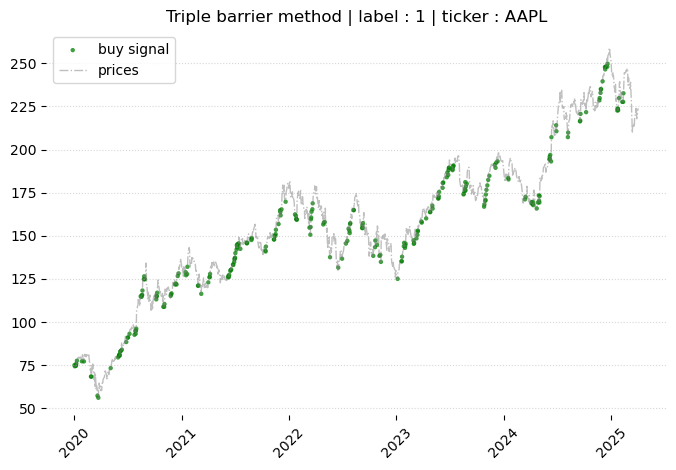

In [30]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    labels[labels['bin'] == 1]['2020':].index,
    data.loc[labels[labels['bin'] == 1].index]['2020':]['Close'],
    marker = 'o',
    edgecolor = 'none',
    alpha = 0.75,
    s = 10,
    color = 'green',
    label = 'buy signal'
)
ax.plot(
    data['2020':]['Close'],
    alpha = 0.5,
    color = 'gray',
    lw = 1,
    label = 'prices',
    ls = '-.'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.legend()
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xticks(rotation = 45)
plt.title('Triple barrier method | label : 1 | ticker : AAPL')
plt.show()

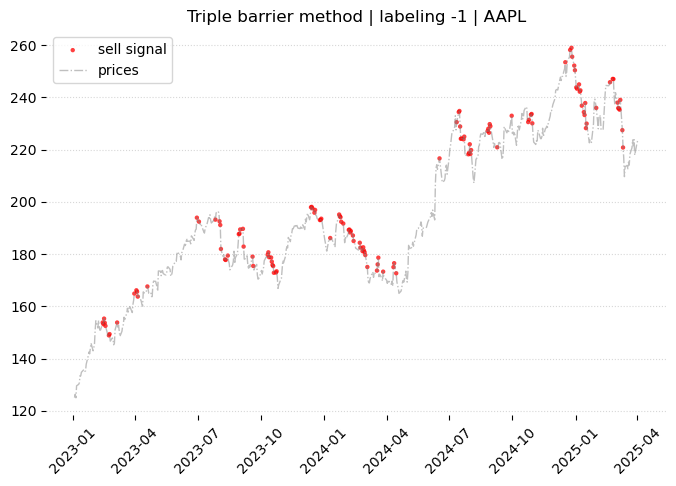

In [31]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    labels[labels['bin'] == -1]['2023':].index,
    data.loc[labels[labels['bin'] == -1].index]['2023':]['Close'],
    marker = 'o',
    edgecolor = 'none',
    alpha = 0.75,
    s = 10,
    color = 'red',
    label = 'sell signal'
)
ax.plot(
    data['2023':]['Close'],
    alpha = 0.5,
    color = 'gray',
    lw = 1,
    label = 'prices',
    ls = '-.'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.legend()
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xticks(rotation = 45)
plt.title('Triple barrier method | labeling -1 | AAPL')
plt.show()

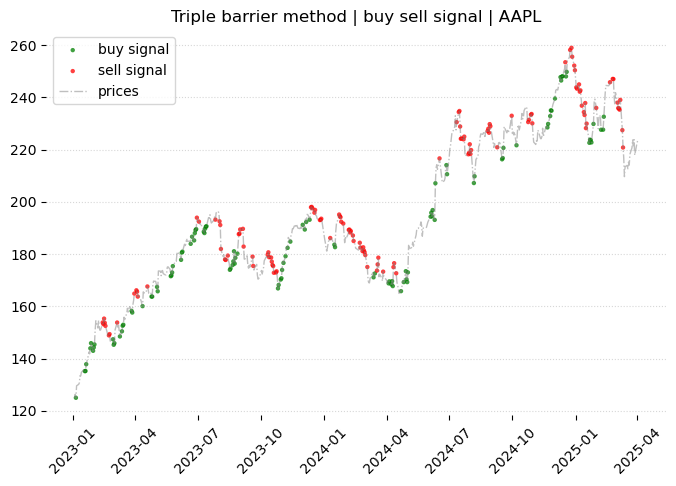

In [32]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    labels[labels['bin'] == 1]['2023':].index,
    data.loc[labels[labels['bin'] == 1].index]['2023':]['Close'],
    marker = 'o',
    edgecolor = 'none',
    alpha = 0.75,
    s = 10,
    color = 'green',
    label = 'buy signal'
)
ax.scatter(
    labels[labels['bin'] == -1]['2023':].index,
    data.loc[labels[labels['bin'] == -1].index]['2023':]['Close'],
    marker = 'o',
    edgecolor = 'none',
    alpha = 0.75,
    s = 10,
    color = 'red',
    label = 'sell signal'
)
ax.plot(
    data['2023':]['Close'],
    alpha = 0.5,
    color = 'gray',
    lw = 1,
    label = 'prices',
    ls = '-.'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.legend()
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xticks(rotation = 45)
plt.title('Triple barrier method | buy sell signal | AAPL')
plt.show()